tested
the final cost of the rrt rountine is:  104.75687588636949


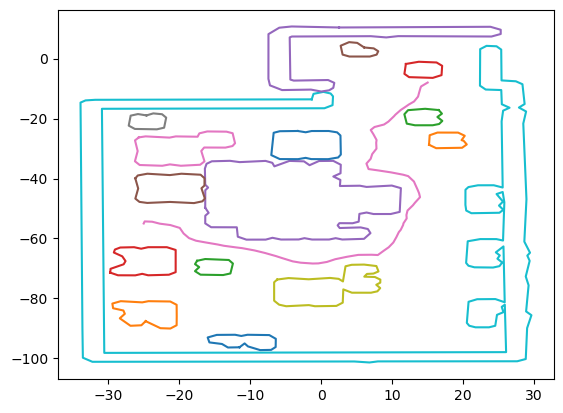

In [3]:
import shapely
import shapely.ops
import numpy as np
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import shape
import random
from rtree import index



class RtreeNode:
    def __init__(self,id,pose,cost,parent=None):
        self.id = id
        self.pose = pose
        self.cost = cost
        self.parent = parent
        self.children = []
        if parent is not None:
            parent.children.append(self)




class RRTstar:
    global start_pos,end_pos
    def __init__(self,map,start_pos,end_pos):

        # initial the rtree
        self.idx = index.Index()

        # buffer the given map
        buffer_map = []
        for n in map.geoms:
            m_b = shapely.Polygon(n.buffer(0.96,join_style=1))
            buffer_map.append(m_b)

        self.map = shapely.unary_union(buffer_map)
        self.start_pos = start_pos
        self.end_pos = end_pos

        # get the boundary of the map, the list contains [min_x, min_y, max_x, max_y]
        self.bound = shapely.bounds(self.map).tolist()

        # print(self.bound)
        # define the number of the samples
        self.num_samples = 2000

        # initial the reach to the goal as false
        self.reach_end = False

        # initial the start search index
        self.forward_step = 0
        self.parent = None

        # initial the id of the node
        self.id = 0
        # initial the start parent in the tree

        # self.nodelist = []
        self.p_list = []
        self.final_trajectory = []

        parent0 = RtreeNode(self.id,self.start_pos,0)
        self.idx.insert(parent0.id,(parent0.pose.x,parent0.pose.y),parent0)
        # self.nodelist.append(parent0)
        # self.p_list.append(self.start_pos)

        # initial the threshold
        self.delta = 3

        # self.p_tree = shapely.STRtree(self.p_list)



        self.get_STree()

    def get_cost_function(self):

        cost = 0.5
        return cost
    
    def get_reach_end(self):
        
        reached = self.reach_end
        return reached
    
    def get_final_trajectory(self):
        final_path = self.final_trajectory
        return final_path

    def get_child_state(self):
        random_x = random.uniform(self.bound[0],self.bound[2])
        random_y = random.uniform(self.bound[1],self.bound[3])
        # check whether the randomed position is contained in the map
        while shapely.contains(self.map,shapely.Point(random_x,random_y)):
            random_x = random.uniform(self.bound[0],self.bound[2])
            random_y = random.uniform(self.bound[1],self.bound[3])

        # indices = self.p_tree.query_nearest(shapely.Point(random_x,random_y))
        p = list(self.idx.nearest((random_x,random_y),1,objects=True))
        # retrieve the parent position

        # parent_point = self.p_tree.geometries.take(indices).tolist()[0]
        parent_point = p[0].object.pose
            

        # get the child position
        cost = self.get_cost_function()

        if(shapely.distance(shapely.Point(random_x,random_y),parent_point)>cost):
            child_x = parent_point.x+(random_x-parent_point.x)*cost/shapely.distance(shapely.Point(random_x,random_y),parent_point)
            child_y = parent_point.y+(random_y-parent_point.y)*cost/shapely.distance(shapely.Point(random_x,random_y),parent_point)
        else:
            child_x = random_x
            child_y = random_y
        
        if(shapely.contains(self.map,shapely.Point(child_x,child_y))):
            return

        # cost_last = shapely.distance(shapely.Point(self.bound[0],self.bound[1]),shapely.Point(self.bound[2],self.bound[3]))
        
        # define a index for the nodelist
        # 1.first find the top 4th nearest point around it
        p_a = list(self.idx.nearest((child_x,child_y),4,objects=True))
        # define a cost list
        cost_l = []
        # define a point list
        # p_l = []
        # find the minimum cost as the current parent
        for c in p_a:
            cost_l.append(c.object.cost+shapely.distance(c.object.pose,shapely.Point(child_x,child_y)))
            # p_l.append(c.object.pose)
        min_index = cost_l.index(min(cost_l))

        self.id +=1

        parent_i = RtreeNode(self.id,shapely.Point(child_x,child_y),min(cost_l),p_a[min_index].object)

        self.idx.insert(parent_i.id, (parent_i.pose.x,parent_i.pose.y),parent_i)

        if shapely.distance(parent_i.pose,self.end_pos) < self.delta:
            self.reach_end = True
            # print("reached to the end")
        # self.reach_end = self.get_reach_end()


    def get_STree(self):
        while not(self.reach_end and self.forward_step>self.num_samples):
            self.get_child_state()
            self.forward_step +=1
        print("tested")

        # index = self.p_tree.query_nearest(self.end_pos)
        # get the top 3 nearest position
        tree_end = list(self.idx.nearest((self.end_pos.x,self.end_pos.y),3,objects=True))
        best_cost = 100000
        last_child = None
        for n in tree_end:
            if shapely.distance(self.end_pos,n.object.pose)+n.object.cost<best_cost:
                best_cost = shapely.distance(self.end_pos,n.object.pose)+n.object.cost
                last_child = n.object


        
        
        print("the final cost of the rrt rountine is: ",best_cost)
        self.final_trajectory.append(self.end_pos)
        while last_child is not None:
            self.final_trajectory.append(last_child.pose)
            last_child = last_child.parent
    



def get_global_map():

    global_map_list = []
    schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
    }

    with fiona.open("/home/acsr/Downloads/ces_compare/extended_polygon.shp") as shapefile:
        for record in shapefile:
            geometry = shape(record['geometry'])

            if shapely.contains(geometry,shapely.Point(-28,-58)):
                continue
            global_map_list.append(geometry)
            # x5,y5 = geometry.exterior.xy
            # xi2,yi2 = geometry.interiors[0].xy
        map_shapely = shapely.unary_union(global_map_list)

        # print(type(map_shapely))
        
    
    # map_polygon = shapely.Polygon()
    return map_shapely

if __name__ == "__main__":
    global_map = get_global_map()
    # print(type(global_map))

    # get the start and end position
    start_point = shapely.Point([15,-8])

    end_point = shapely.Point([-25,-55])

    # create a RRT star search tree
    if shapely.contains(global_map,end_point) or shapely.contains(global_map,start_point):
        print("Invalid start or end position!")
    else:
        rrt_path = RRTstar(global_map,start_point,end_point)

    final_path = rrt_path.get_final_trajectory()

    # save the trajectory data to file

    s_file = open("/home/acsr/Downloads/ces_compare/rrt_data.txt","w")

    for n in reversed(final_path):
        s_file.write(str(n.x))
        s_file.write(",")
        s_file.write(str(n.y))
        s_file.write("\n")

    s_file.close()
    
    for n in global_map.geoms:
        x,y = n.exterior.xy
        plt.plot(x,y)
    
    x_r = []
    y_r = []
    for n in final_path:
        x_r.append(n.x)
        y_r.append(n.y)
    plt.plot(x_r,y_r)
    plt.show()



In [23]:
import numpy as np
n = 3.1415927*2/0.003228
list = [1,2,3,4,5]
list2 = [2,4,6,8,6]
list3_arr = np.multiply(list,list2)
list3 = list3_arr.tolist()
print(str(list3))
list4 = np.add(list,list2)
print(list4)
list5 = np.cos(list)
print(list5)
list6_arr= np.linspace(1,5,5)
list6 = list6_arr.tolist()
print(list6)

list7 = np.multiply(list,2).tolist()

print(list7)
list8 = np.sqrt(list4).tolist()
print(list8)
list9 = np.power(list,2).tolist()
print(list9)

[2, 8, 18, 32, 30]
[ 3  6  9 12 11]
[ 0.54030231 -0.41614684 -0.9899925  -0.65364362  0.28366219]
[1.0, 2.0, 3.0, 4.0, 5.0]
[2, 4, 6, 8, 10]
[1.7320508075688772, 2.449489742783178, 3.0, 3.4641016151377544, 3.3166247903554]
[1, 4, 9, 16, 25]
